<a href="https://colab.research.google.com/github/AnushkaAmte/Preprocessing/blob/main/handwriting_recognitionipynb_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [11]:
!ls gdrive/MyDrive

'01 immortals of meluha - amish tripathi.pdf'
 1019104_Anushka_Amte_Task1.pdf
 1019104_Anushka_Amte_Task1.zip
 1019104_Resume
'12 Board Certificate.pdf'
 1681801142.mp4
 2005_Book_AModernIntroductionToProbabili.pdf
'2021_05_17 3_38 pm Office Lens.pdf'
 31444.pdf
 Abstract.gdoc
 Acknowledgement_Slip.pdf
'Anushka Amte 1019104.jpeg'
'Anushka Amte GCC2.0_Participation Certificate.pdf'
'Anushka Amte Mains Result.pdf'
'Anushka-resume (2).pdf'
 AOA-CHAPTER-4.pdf
 AOA-CHAPTER-5.pdf
'Apple Invoice IPad.pdf'
'Apple Pencil Tax Invoice.pdf'
'A Song Of Ice And Fire'
 BG.tiff
 Camera
'CAP round 1.pdf'
'Certificate for Anushka Amte for "App Development".pdf'
'Certificate for Anushka Amte for "Departmental Webinar 2021 -...".pdf'
'Certificate New.pdf'
'Certificates (1).gdoc'
'Certificates (1)-merged.pdf'
 Certificates.gdoc
 Certificates.pdf
'CET result.pdf'
'CG Mini Project.gslides'
 ch1.pdf
'CodeBash 2k21 Attendance 2.gsheet'
'CodeBash Attendance 1.gsheet'
'Colab Notebooks'
 Conclusion.gdoc
'control 

In [2]:
!unzip gdrive/MyDrive/IAM_Words.zip

Archive:  gdrive/MyDrive/IAM_Words.zip
   creating: IAM_Words/
  inflating: IAM_Words/words.tgz     
  inflating: IAM_Words/words.txt     


In [3]:
!mkdir data
!mkdir data/words

In [4]:
!tar -xf IAM_Words/words.tgz -C data/words

In [5]:
!mv IAM_Words/words.txt data

In [6]:
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from numpy.core.numeric import indices
from numpy.testing._private.utils import assert_

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from tensorflow._api.v2 import image

from tensorflow.python.ops.gen_array_ops import pad

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
np.random.seed(42)

tf.random.set_seed(42)

In [9]:
base_path = "data"
words_list = []

words =open(f"{base_path}/words.txt","r").readlines()

for line in words:
    if line[0] == '#':
        continue
    if line.split(" ")[1] != "err":
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)
print(len(words_list))

96456


In [10]:
split_idx = int(0.9 * len(words_list))
train_samples= words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[: val_split_idx]
test_samples =test_samples[val_split_idx:]

assert_ 
len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total testing samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total testing samples: 4823


In [11]:
base_image_path= os.path.join(base_path,"words")

def get_image_paths_and_labels(samples):
    paths= []
    corrected_samples=[]
    for (i,file_line) in enumerate(samples):
        line_split= file_line.strip()
        line_split = line_split.split(" ")


        image_name = line_split[0]
        part1= image_name.split("-")[0]
        part2 = image_name.split("-")[1]
        img_path= os.path.join(base_image_path,part1,part1 + "-"+ part2,image_name + ".png")

        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples) 
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [12]:
train_labels_cleaned = []
characters = set()
max_len=0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len= max(max_len,len(label))
    train_labels_cleaned.append(label)

print("Max length: ",max_len)
print("vocab size: ",len(characters))

print(" ", train_labels_cleaned[:10])

def clean_labels(labels):
    cleaned_labels=[]
    for label in labels:
        label=label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned= clean_labels(test_labels)

Max length:  21
vocab size:  78
  ['sure', 'he', 'during', 'of', 'booty', 'gastronomy', 'boy', 'The', 'and', 'in']


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

def distortion_free_resize(image,img_size):
    w,h= img_size
    image= tf.image.resize(image,size=(h,w),preserve_aspect_ratio=True)

    pad_height = h- tf.shape(image)[0]
    pad_width = w- tf.shape(image)[1]

    if pad_height%2 !=0:
        heigth = pad_height //2
        pad_height_top = heigth +1
        pad_height_bottom =heigth
    else: 
        pad_height_top = pad_height_bottom = pad_height //2

    if pad_width %2 !=0:
        width = pad_width //2
        pad_width_left = width +1
        pad_width_right = width
    else:
        pad_width_left= pad_width_right = pad_width //2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top,pad_height_bottom],
            [pad_width_left,pad_width_right],
            [0,0]
        ],
    )

    image =tf.transpose(image, perm=[1,0,2])
    image =tf.image.flip_left_right(image)
    return image

In [14]:
batch_size =64
padding_token =99
image_width =128
image_height = 32

def preprocess_image(image_path, img_size=(image_width,image_height)):
    image= tf.io.read_file(image_path)
    image = tf.image.decode_png(image,1)
    image= distortion_free_resize(image,img_size)
    image =tf.cast(image, tf.float32) / 255.0

    return image

def vectorize_label(label):
    label= char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length= tf.shape(label)[0]
    pad_amount = max_len -length
    label= tf.pad(label, paddings=[[0,pad_amount]],constant_values=padding_token)

    return label

def process_image_labels(image_path,label):
    image = preprocess_image(image_path)
    label= vectorize_label(label)

    return {"image": image, "label": label}

def prepare_datset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_image_labels, num_parallel_calls= AUTOTUNE
    )

    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


train_ds = prepare_datset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_datset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_datset(test_img_paths, test_labels_cleaned)

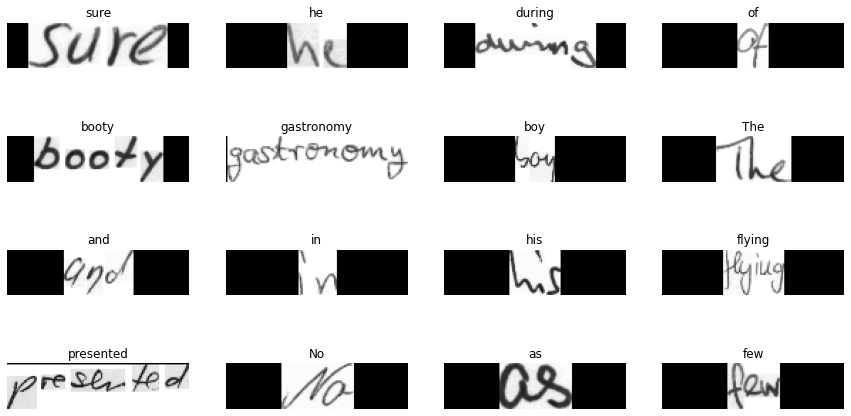

In [15]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4,4, figsize = (15,8))
    for i in range(16):
        img = images[i]
        img= tf.image.flip_left_right(img)
        img = tf.transpose(img,perm=[1,0,2])
        img= (img *255.0).numpy().clip(0,255).astype(np.uint8)
        img =img [:,:,0]

        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))

        label =tf.strings.reduce_join(num_to_char(indices))

        label = label.numpy().decode("utf-8")

        ax[i //4, i% 4].imshow(img,cmap="gray")
        ax[i //4, i% 4].set_title(label)
        ax[i//4,i%4].axis("off")

plt.show()

In [16]:
tf.version.VERSION

'2.7.0'

In [ ]:
!pip freeze 

In [22]:
class CTCLayer(keras.layers.Layer):
  def __init__(self,name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost


  def call(self,y_true, y_pred):
    batch_len= tf.cast(tf.shape(y_true)[0], dtype = "int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype= "int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")


    input_length = input_length * tf.ones(shape=(batch_len,1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len,1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    return y_pred




def build_model():
  input_img = keras.Input(shape=(image_width,image_height,1), name="image")
  labels = keras.layers.Input(name="label",shape=(None,))

  x = keras.layers.Conv2D(
      32,
      (3,3),
      activation = "relu",
      padding = "same",
      name = "conv1"
  )(input_img)

  x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)



  x = keras.layers.Conv2D(
      64,
      (3,3),
      activation = "relu",
      kernel_initializer = "he_normal",
      padding = "same",
      name = "conv2",
  )(x)


  x=  keras.layers.MaxPooling2D((2,2), name= "pool2")(x)



  new_shape = ((image_width // 4),(image_height // 4) *64)

  x =keras.layers.Reshape(target_shape= new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation = "relu",name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)


  x= keras.layers.Bidirectional(
      keras.layers.LSTM(128, return_sequences=True,dropout=0.25)
  )(x)

  x= keras.layers.Bidirectional(
      keras.layers.LSTM(64, return_sequences= True,dropout=0.25)
  )(x)

  x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)
  output = CTCLayer(name = "ctc_loss")(labels,x)

  model = keras.models.Model(
      inputs = [input_img, labels], outputs= output, name = "handwriting_recognizer"
  )

  opt = keras.optimizers.Adam()

  model.compile(optimizer= opt)

  return model

model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [23]:
validation_images = []
validation_labels = []

for batch in validation_ds:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])

  

In [27]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )
    #print(type(input_len))
   
    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)




In [28]:
class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print( f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}")

In [29]:
epochs = 50  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/50
1357/1357 [==============================] - 177s 124ms/step - loss: 13.7340 - val_loss: 12.3158
Epoch 2/50
1357/1357 [==============================] - 163s 120ms/step - loss: 11.5279 - val_loss: 10.5635
Epoch 3/50
1357/1357 [==============================] - 162s 119ms/step - loss: 9.9242 - val_loss: 9.2395
Epoch 4/50
1357/1357 [==============================] - 163s 120ms/step - loss: 8.7985 - val_loss: 8.0657
Epoch 5/50
1357/1357 [==============================] - 163s 120ms/step - loss: 7.7610 - val_loss: 6.7814
Epoch 6/50
1357/1357 [==============================] - 164s 121ms/step - loss: 6.6613 - val_loss: 5.6196
Epoch 7/50
1357/1357 [==============================] - 162s 119ms/step - loss: 5.7411 - val_loss: 4.6619
Epoch 8/50
1357/1357 [==============================] - 162s 119ms/step - loss: 4.9971 - val_loss: 4.0490
Epoch 9/50
1357/1357 [==============================] - 162s 120ms/step - loss: 4.4732 - val_loss: 3.5590
Epoch 10/50
1357/1357 [===================

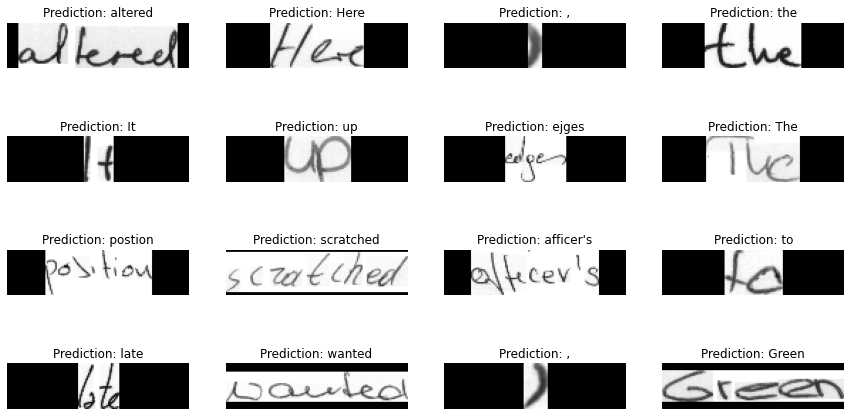

In [30]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()


In [31]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [32]:
from google.colab import files
files.download("/content/saved_model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>